https://github.com/nipy/nipype/issues/975#issuecomment-60278251

I'm not 100% sure, but I think the problem is the difference between a MapNode and a normal Node that uses iterables.

If I use you're code @sgiavasis, it does only work as you want it to work, if the aggregate Node is a normal node (not a JoinNode):

    aggregate = pe.Node(util.Function(input_names=['info_list'],
                                      output_names=['info_pickle'],
                                      function=aggregate_values),
                                      name='aggregate_values')

If you want to use a JoinNode you have to use a normal Node that iterates over the input, e.g.:

    inputs_list = [0.99, 0.98, 0.90]

    workflow = pe.Workflow(name='correlations_workflow')
    workflow.base_dir = current_dir + '/correlations'

    infosource = pe.Node(util.IdentityInterface(fields=['input_array']),
                         name="infosource")
    infosource.iterables = ('input_array', inputs_list)

    aggregate = pe.JoinNode(util.Function(input_names=['info_list'],
                                          output_names=['info_pickle'],
                                          function=aggregate_values),
                                          joinsource='infosource',
                                          joinfield='info_list',
                            name='aggregate_values')

    datasink = pe.Node(nio.DataSink(), name='sinker')
    datasink.inputs.base_directory = current_dir + '/file_output'

    workflow.connect(infosource, 'input_array', aggregate, 'info_list')
    workflow.connect(aggregate, 'info_pickle', datasink, 'output')

    workflow.run()

This also results in an output file that contains all values of the list.

I think a MapNode treates a multi cell input just internally as multiple objects, but sends the desired output value to the next node in one list. While a normal Node with iterables actually creates multiple instances of this node.

# From Satra

In [ ]:
from nipype import Workflow, JoinNode, Node
from nipype.interfaces.utility import Function

## Two node JoinNode demonstration

The first node serves the _iterables_ and the second node aggregates and processes them. 

In [ ]:
def get_data_from_id(id):
    import numpy as np
    return id + np.random.rand()

def merge_and_scale_data(data2):
    import numpy as np
    return (np.array(data2) * 1000).tolist()

node1 = Node(Function(input_names=['id'],
                      output_names=['data1'],
                      function=get_data_from_id),
             name='get_data')
node1.iterables = ('id', [1, 2, 3])

node2 = JoinNode(Function(input_names=['data2'],
                          output_names=['data_scaled'],
                          function=merge_and_scale_data),
                 name='scale_data',
                 joinsource=node1,
                 joinfield=['data2'])

wf = Workflow(name='testjoin')
wf.connect(node1, 'data1', node2, 'data2')
eg = wf.run()

In [ ]:
res = [node for node in eg.nodes() if 'scale_data' in node.name][0].result

In [ ]:
res.outputs


data_scaled = [1183.4866681622457, 2183.4866681622457, 3183.4866681622457]

In [ ]:
res.inputs

{'data2': [1.1834866681622458, 2.183486668162246, 3.183486668162246],
 'function_str': u'def merge_and_scale_data(data2):\n    import numpy as np\n    return (np.array(data2) * 1000).tolist()\n',
 'ignore_exception': False}

In [ ]:
eg.edges(data=True)

[(testjoin.get_data.aI.a0,
  testjoin.scale_data,
  {'connect': [('data1', 'data2J1')]}),
 (testjoin.get_data.aI.a2,
  testjoin.scale_data,
  {'connect': [('data1', 'data2J3')]}),
 (testjoin.get_data.aI.a1,
  testjoin.scale_data,
  {'connect': [('data1', 'data2J2')]})]

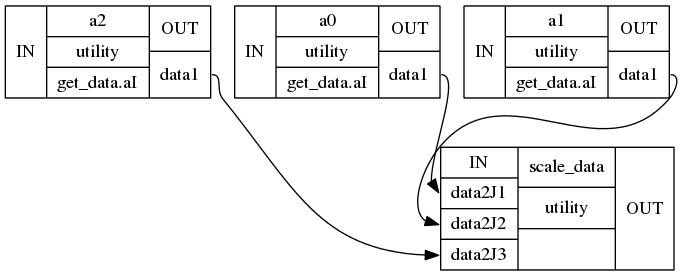

In [ ]:
wf.write_graph(graph2use='exec')
from IPython.display import Image
Image(filename='graph_detailed.dot.png')

## Extending to multiple nodes

We extend the workflow by using three nodes. Note that even this workflow, the `joinsource` corresponds to the node containing _iterables_ and the `joinfield` corresponds to the input port of the `JoinNode` that aggregates the iterable branches. As before the graph below shows how the execution process is setup.

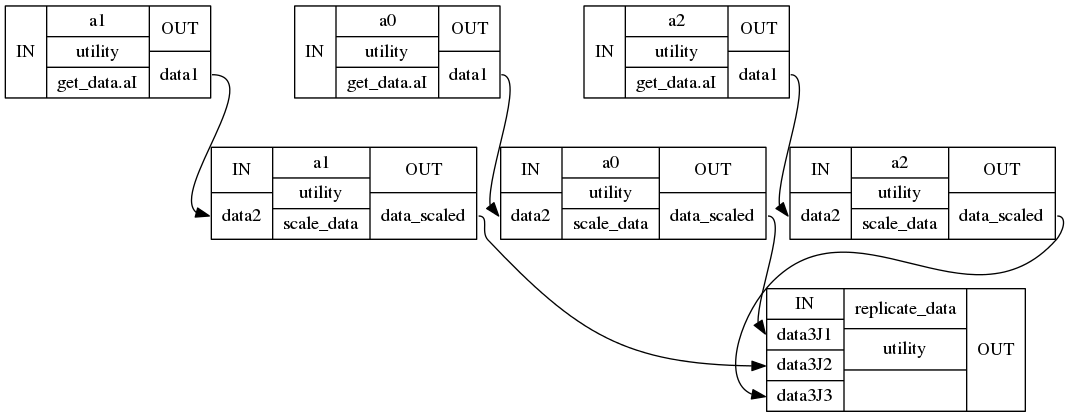

In [ ]:
def get_data_from_id(id):
    import numpy as np
    return id + np.random.rand()

def scale_data(data2):
    import numpy as np
    return data2

def replicate(data3, nreps=2):
    return data3 * nreps

node1 = Node(Function(input_names=['id'],
                      output_names=['data1'],
                      function=get_data_from_id),
             name='get_data')
node1.iterables = ('id', [1, 2, 3])

node2 = Node(Function(input_names=['data2'],
                      output_names=['data_scaled'],
                      function=scale_data),
             name='scale_data')

node3 = JoinNode(Function(input_names=['data3'],
                          output_names=['data_repeated'],
                          function=replicate),
                 name='replicate_data',
                 joinsource=node1,
                 joinfield=['data3'])

wf = Workflow(name='testjoin')
wf.connect(node1, 'data1', node2, 'data2')
wf.connect(node2, 'data_scaled', node3, 'data3')
eg = wf.run()

wf.write_graph(graph2use='exec')
Image(filename='graph_detailed.dot.png')